# Odvisnost temperature razlike in pretoka v toplovodu
Določiti želimo pretok v ceveh na podlagi časovnega zamika pri širjenju temperaturnega profila med dvema merilnima mestoma, kjer se meri temperatura vode. 

In [1]:
# knjižnice, ki jih potrebujemo
%pylab
import pandas as pd

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [6]:
# podatki o temperaturah 
temp_1 = pd.read_csv("MurEF_T1.csv",index_col="Time",delimiter=";")
#temp_2 = pd.read_csv("MUR_EF.csv",delimiter=";")

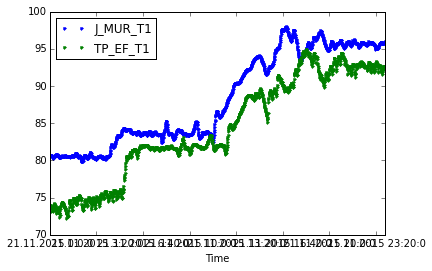

In [7]:
%matplotlib inline
temp_1.plot(style=".",ylim=[70,100])

In [15]:
s1 = temp_1.TP_EF_T1
s2 = temp_1.J_MUR_T1

(80, 100)

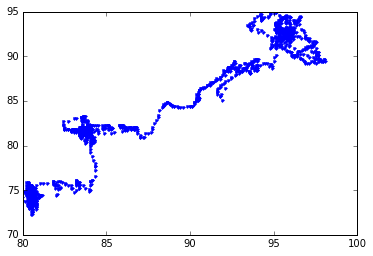

In [16]:
T1T2 = temp_1.as_matrix()
T1 = T1T2[:,0]
T2 = T1T2[:,1]
plot(T1,T2,'.')
xlim([80,100])

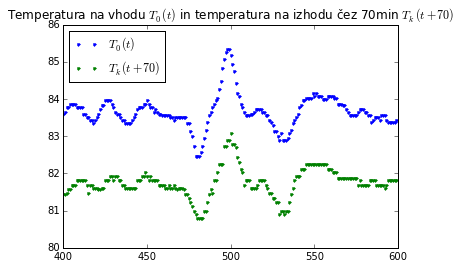

In [18]:
okno = arange(200)
t = 400
tau = 70
plot(t+okno,T1[t+okno],'.',label="$T_0(t)$")
plot(t+okno,T2[t+okno+tau],'.',label="$T_k(t+%d)$"%tau)
legend(loc=2)
title("Temperatura na vhodu $T_0(t)$ in temperatura na izhodu čez 70min $T_k(t+%d)$"%tau)

Korelacijskiki koeficient pri optimalnem zamiku 71 je 0.922135


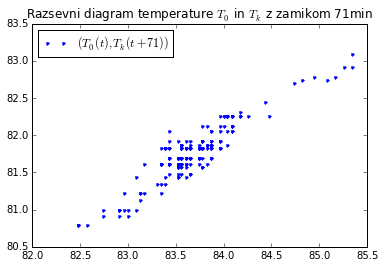

In [19]:
dt = 200
t=400
tau,r = opt_zamik(T1,T2,t,dt)
okno = arange(dt)
plot(T1[t+okno],T2[t+okno+tau],'.',label="$(T_0(t),T_k(t+%d))$"%tau)
legend(loc=2)
title("Razsevni diagram temperature $T_0$ in $T_k$ z zamikom %dmin"%tau)
print("Korelacijskiki koeficient pri optimalnem zamiku %d je %f" % (tau,r))

## Določitev časovnega zamika

Če na isti graf narišemo potek temperatur na obeh merilnih mestih, vidimo, da sta grafa zamaknjena. Iz podatkov o temperaturi na začetnem $T_0(t)$ in končnem merilnem mestu $T_k(t)$, bi radi določili časovni zamik $\tau$. Časovni zamik poiščemo z naslednjim postopkom.

 * Izberemo „časovno okno“, to je časovni interval $[t,t+\delta t]$
 * za različne vrednosti $\tau$, izračunamo korelacijski koeficient med signalom $T_0$ na $[t,t+\delta t]$ in signalom $T_k$ na intervalu $[t+\tau,t+\delta t +\tau]$
 $$\rho(T_0(T),T_k(t+\tau)\text{ na }[t,t+\delta t].$$
 * iskani časovni zamik je tisti, pri katerem je korelacija največja
 $$\tau_m = \max_{\tau}\rho(T_0(t),T_k(t+\tau))$$

In [83]:
def opt_zamik(T1,T2,t,dt,plot_graph=False):
    """Izračuna zamik tau, pri katerem sta obe časovni vrsti najbolj poravnani."""
    okno = arange(dt)
    m = 0
    tau_m = 0
    tau_list = range(40,120)
    r_list = []
    for tau in tau_list:
        r = corrcoef(T1[okno+t],T2[okno+tau+t])[0,1]
        r_list.append(r)
        if r>m:
            tau_m = tau
            m = r
    r_list = array(r_list)
    tv = sum(abs(r_list[1:]-r_list[:-1]))/len(tau_list)        
    rp = average(r_list)
    if plot_graph:
        fig = plt.figure(figsize=(12, 4))
        subplot(121)
        plot(tau_list,r_list,'.')
        plot(tau_list,rp*ones(len(tau_list)),'r-')
        xlabel("časovni zamik $\\tau$")
        ylabel("korelacijski koef. $\\rho(T_0(t),T_k(t+\\tau))$")
        plot([tau_m,tau_m],[-1,m],'ro-',)
        annotate("$\\tau_m$",xy = [tau_m+0.5,-0.9])
        title("$\\rho(T_0(t),T_k(t+\\tau))$ v odvisnosti od $\\tau$")
        subplot(122)
        plot(okno+t,T1[okno+t],label="$T_0(t)$")
        plot(okno+t,T2[okno+tau_m+t],label="$T_k(t+%d)$"%tau_m)
        xlabel("čas $t$ v minutah")
        ylabel("temperatura T v °C")
        title("$T_0(t)$ in $T_k(t+\\tau)$")
        legend()
    return (tau_m,m,rp,tv)


(71, 0.9533294654158796, -0.084723610516932266, 0.050036692305754249)

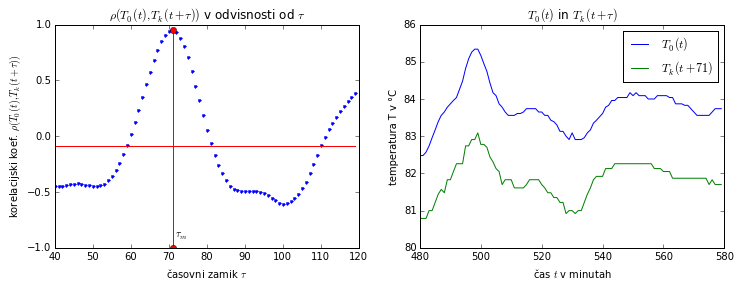

In [84]:
opt_zamik(T1,T2,480,100,plot_graph=True)

62 0.943427826435 0.519195885061 0.0237147622093


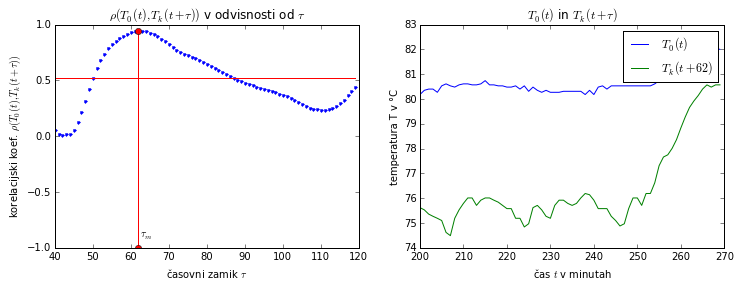

In [85]:
from ipywidgets import interact
@interact(t=(1,1200,20),dt=(50,150))
def zamik(t=200,dt=70):
    tau,r,rp,tv = opt_zamik(T1,T2,t,dt,plot_graph=True)
    print(tau,r,rp,tv)

## Omejitve
Če tempraturna odvisnost nima značilnih oblik, časovnega zamika $\tau$  ni mogoče zanesljivo določiti. Vrednost $\tau$, pri katerem je korelacijski koeficient maksimalen, je precej občutljiv na šum. V tem primeru je korelacijski koeficient skoraj neodvisen od $\tau$ in je povprečen $\rho$ velik. 

(88, 0.97876089239830222, 0.78523955553921942, 0.013007957879135895)

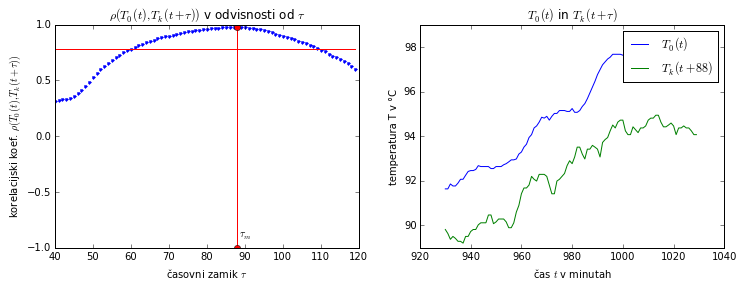

In [86]:
opt_zamik(T1,T2,930,100,plot_graph=True)

Drug primer, ko časovnega zamika ne moremo zanesljivo določiti, če temperatura niha. V tem primeru je več možnih kandidatov. Povprečen korelacijski koeficient $\rho$ je sicer blizu nič, vendar pa je totalna variacija v tem primeru velika.

(73, 0.68536965221466317, 0.02326388079652169, 0.093028930335482304)

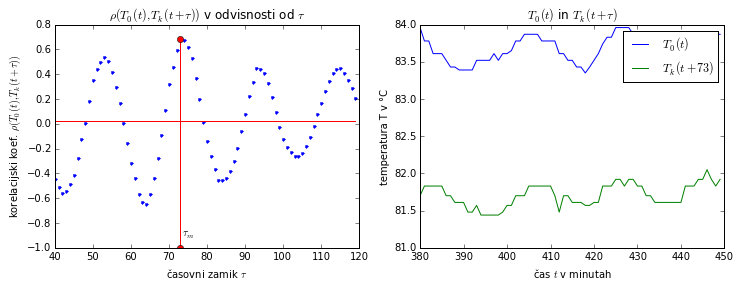

In [87]:
opt_zamik(T1,T2,380,70,plot_graph=True)

## Rezultati

In [74]:
dt = 70
tau_list = []
t_list = []
for t in range(1250):
    tau,r,rp,tv = opt_zamik(T1,T2,t,dt)
    if r>0.8 and rp<0.1: # and tv<0.06 and tv>0.04:
        tau_list.append((tau,r,rp,tv)) 
        t_list.append(t)
tau_m = array(tau_list)

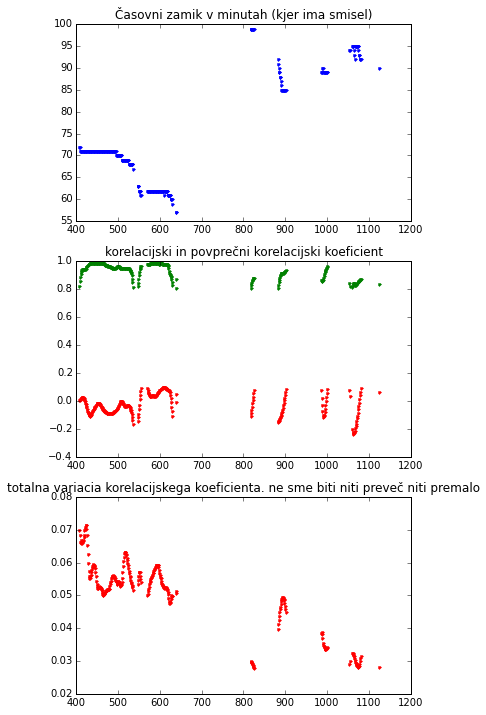

In [88]:
figure(figsize=(6,12))
subplot(311)
plot(t_list,tau_m[:,0],'.')
title("Časovni zamik v minutah (kjer ima smisel)")
subplot(312)
plot(t_list,tau_m[:,1],'.g')
plot(t_list,tau_m[:,2],'.r')
title("korelacijski in povprečni korelacijski koeficient")
subplot(313)
plot(t_list,tau_m[:,3],'.r')
title("totalna variacia korelacijskega koeficienta. ne sme biti niti preveč niti premalo")

In [56]:
tau_m

array([   0,    1,    2, ..., 1247, 1248, 1249])

Korelacijskiki koeficient pri optimalnem zamiku 80 je 0.922135


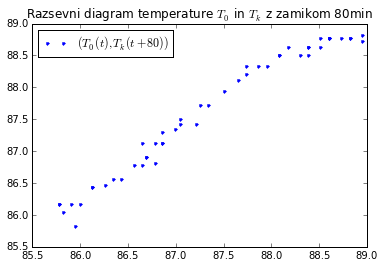

In [169]:
plot(T1[t+okno],T2[t+okno+tau],'.',label="$(T_0(t),T_k(t+%d))$"%tau)
legend(loc=2)
title("Razsevni diagram temperature $T_0$ in $T_k$ z zamikom %dmin"%tau)
print("Korelacijskiki koeficient pri optimalnem zamiku %d je %f" % (tau,r))

In [143]:
dt = 200
t=400
for t in range(10,1000,20):
    tau,r = opt_zamik(T1,T2,t,dt)
    print(t,tau,r)

10 55 0.0547470409442
30 54 0.0547418115475
50 0 0
70 64 0.682263454515
90 59 0.879393414506
110 56 0.934749278995
130 54 0.946422528173
150 50 0.956096104058
170 57 0.960460913436
190 57 0.963075004089
210 59 0.956573903063
230 58 0.94206100117
250 36 0.896056068318
270 36 0.805133126177
290 73 0.781445653682
310 72 0.895437698938
330 72 0.914866612628
350 71 0.903120308378
370 71 0.914410758204
390 71 0.931429905755
410 70 0.864281272378
430 69 0.817214813766
450 67 0.749226429467
470 67 0.736343986153
490 67 0.694740100908
510 59 0.710226340777
530 58 0.90553096971
550 58 0.962774965723
570 58 0.980643715896
590 57 0.988398216863
610 57 0.991229974283
630 56 0.990723132355
650 55 0.98801953078
670 51 0.966685452583
690 20 0.95122064019
710 20 0.922831825394
730 20 0.85564762321
750 20 0.76338794016
770 20 0.661226802628
790 104 0.77182615736
810 97 0.872303060505
830 89 0.911603530427
850 88 0.949766440561
870 89 0.951353619979
890 88 0.970564935603
910 89 0.953864229922
930 90 0.94

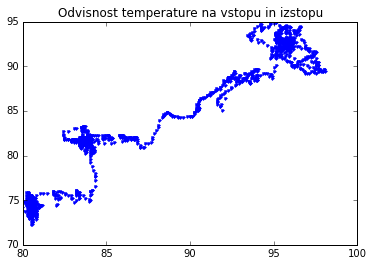

In [102]:
%matplotlib inline
clf()
plot(series.J_MUR_T1,series.TP_EF_T1,'.')
xlim([80,100])
title("Odvisnost temperature na vstopu in izstopu")

In [104]:
series.describe()

,J_MUR_T1,TP_EF_T1
count,1440.000000,1440.000000
mean,88.291458,84.422118
std,6.655077,6.850796
min,0.000000,72.280000
25%,83.390000,80.980000
50%,85.950000,82.260000
75%,95.290000,91.420000
max,98.060000,94.940000


In [119]:
series

,J_MUR_T1,TP_EF_T1
Time,,
21.11.2015 0:0:0,80.79,74.06
21.11.2015 0:1:0,80.79,74.06
21.11.2015 0:2:0,80.79,73.88
21.11.2015 0:3:0,80.79,73.80
21.11.2015 0:4:0,80.79,73.80
21.11.2015 0:5:0,80.79,73.19
21.11.2015 0:6:0,80.70,73.67
21.11.2015 0:7:0,80.61,73.67
21.11.2015 0:8:0,80.53,73.58
